# Main of the paper - LSR - $\sigma \neq 0.4$

In this notebook are gathered all experiments generated for the main of the paper using a least-squares regression which require presence of noise.

In [1]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import RMSEModel, build_several_cost_model

from src.machinery.GradientDescent import ArtemisDescent, DianaDescent, FL_VanillaSGD
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.Constants import *
from src.utils.DataPreparation import build_data_linear, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "with_noise"

nb_devices_for_the_run = 10
dim_notebook = 20
MAX_NB_DEVICES = 40

In [2]:
# Building data
w_true = generate_param(dim_notebook)
X, Y = build_data_linear(w_true, n_dimensions = dim_notebook, 
                         n_devices=MAX_NB_DEVICES, with_seed=False, without_noise=False)
X = add_bias_term(X)
print(X[0].shape)
pickle_saver((X, Y), filename + "-data")

torch.Size([200, 21])


Text(0.5, 1.0, 'Model weights')

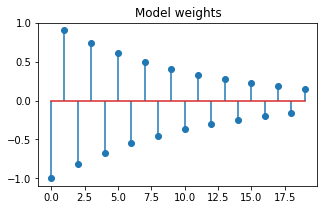

In [3]:
plt.figure(figsize=(5, 3))
plt.stem(w_true, use_line_collection=True)
plt.title("Model weights")

In [4]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(RMSEModel, X, Y, nb_devices_for_the_run)

In [5]:
%%time
obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook + 1, 
                                                     nb_devices=nb_devices_for_the_run,
                                                     nb_epoch=20000, 
                                                     momentum=0., 
                                                     quantization_param=0,
                                                     verbose=True, 
                                                     cost_models=cost_models,
                                                     stochastic=False,
                                                     bidirectional=False,
                                                    ))
obj_min_by_N_descent.run(cost_models)
obj_min_by_N = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min_by_N, filename + "-obj_min")

   it    |   obj   
    4000 | 1.3440e-01
    8000 | 1.3440e-01
   12000 | 1.3440e-01
   16000 | 1.3440e-01
Gradient Descent: execution time=220.919 seconds
Final loss : 0.13440

CPU times: user 1min 29s, sys: 158 ms, total: 1min 30s
Wall time: 3min 41s


In [6]:
obj_min_by_N_descent.model_params[-1]

tensor([ 2.1778, -0.9872,  0.8980, -0.8188,  0.7335, -0.6668,  0.6047, -0.5542,
         0.4902, -0.4356,  0.3970, -0.3758,  0.3343, -0.2941,  0.2813, -0.2567,
         0.2181, -0.1848,  0.1881, -0.1777,  0.1589], dtype=torch.float64)

In [7]:
%%time
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, 
                                               step_formula=deacreasing_step_size)
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-descent")

100%|██████████| 5/5 [2:01:57<00:00, 1463.48s/it]

CPU times: user 39min 36s, sys: 1.65 s, total: 39min 37s
Wall time: 2h 1min 57s


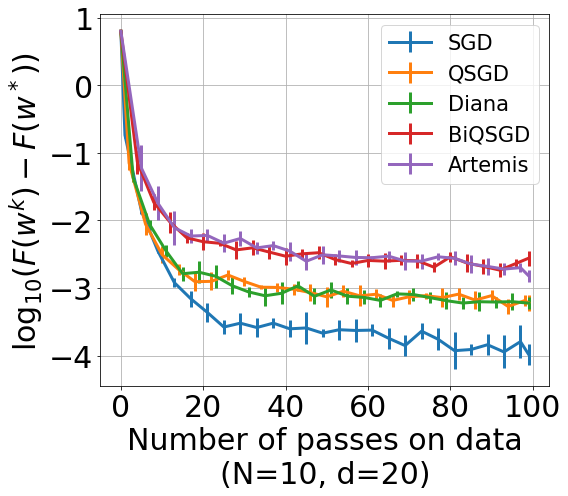

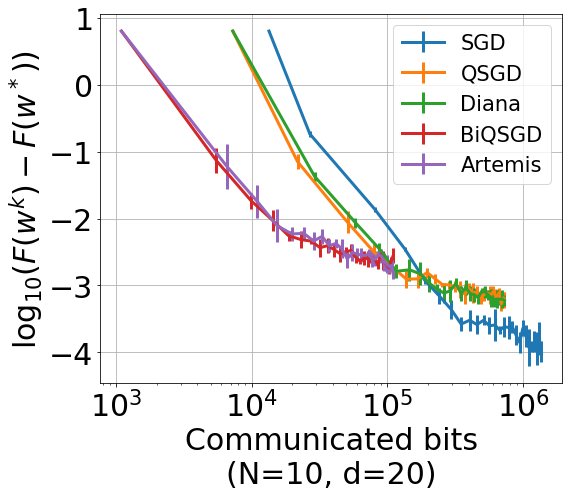

In [8]:
obj = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj)) 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits", all_error=res.get_std(obj))  


## Devices sampling

In [9]:
%%time
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, 
                                               step_formula=deacreasing_step_size, fraction_sampled_workers=0.5)
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-descent")

100%|██████████| 5/5 [45:45<00:00, 549.14s/it]

CPU times: user 25min 19s, sys: 883 ms, total: 25min 20s
Wall time: 45min 45s


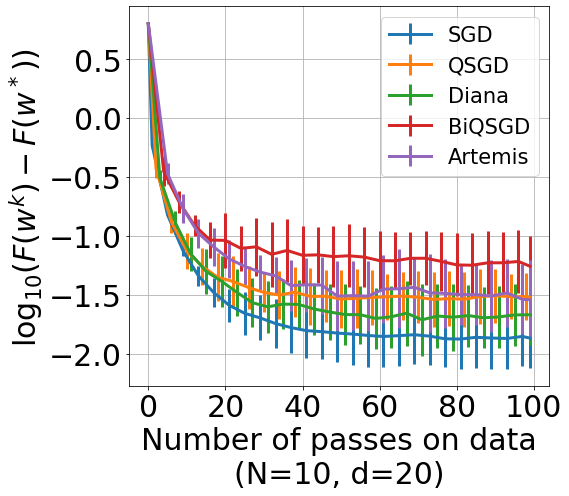

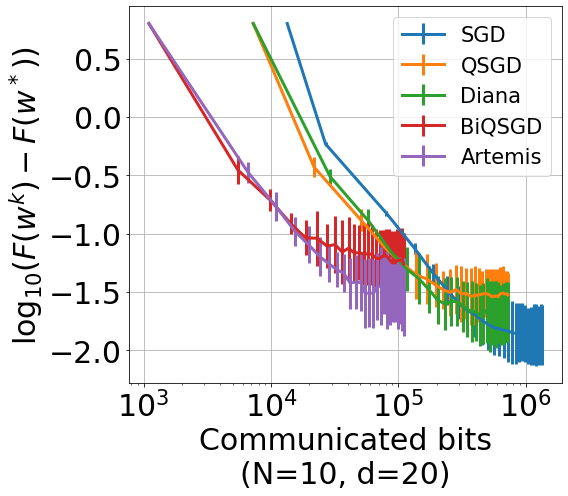

In [10]:
obj = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj)) 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits", all_error=res.get_std(obj))  
